# Tobamovirus Classification Model: Results Analysis

This notebook provides a comprehensive analysis of the machine learning pipeline results for tobamovirus classification. The analysis covers three main components:

1. Model Selection: Comparison of different algorithms
2. Model Evaluation: Performance assessment using different contig prediction methods
3. **Final Model**: Feature importance analysis and model characteristics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-ready figures
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Define paths (adjusted for notebook location in notebooks folder)
base_dir = Path('/home/tobamo/analize/project-tobamo/analysis/model')
results_dir = base_dir / 'results'
figures_dir = base_dir / 'figures'
model_selection_dir = results_dir / 'model_selection_test_n5'
evaluation_dir = results_dir / 'evaluation_results'
final_model_dir = results_dir / 'final_model'

# Create figures directory if it doesn't exist
figures_dir.mkdir(exist_ok=True)

## C1. Feature importance analysis

Analysis of the final trained model including feature importance and model characteristics.

In [3]:
# Load final model results
feature_importance = pd.read_csv(final_model_dir / 'top_40_features.csv')
all_features = pd.read_csv(final_model_dir / 'all_features.csv')

print(f"Total features in final model: {len(all_features)}")
print(f"Top 40 features analyzed: {len(feature_importance)}")
print(f"\nTop 10 most important features:")
print("=" * 50)
for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
    print(f"{i+1:2d}. {row['Feature']:<40} {row['Importance']:.6f}")

Total features in final model: 148
Top 40 features analyzed: 40

Top 10 most important features:
 1. tobamo_orf1_identity_score_max           0.021722
 2. outgroup_orf1_identity_score_max         0.021600
 3. outgroup_orf2_identity_score_max         0.016309
 4. stop_codons                              0.016285
 5. outgroup_orf2_identity_score_mean        0.015451
 6. outgroup_orf2_identity_score_min         0.015112
 7. outgroup_orf1_N/aln_len_max              0.014921
 8. tobamo_orf1_N/aln_len_max                0.014522
 9. tobamo_orf1_gap_openings_min             0.014490
10. outgroup_orf2_gap_ratio_mean             0.013380


## Aggregating metrices

This section provides a comprehensive analysis of feature composition and statistical significance of feature enrichment in the top 40 most important features. We examine two main aggregation approaches:

1. **Metric-based aggregation**: Features grouped by alignment metrics (identity_score, gap_ratio, gap_openings, aln_len, aln_orf_len, N/aln_len)
2. **Protein-based aggregation**: Features grouped by protein regions (orf1, orf2, cp)

For each aggregation, we perform hypergeometric tests to determine if certain feature types are statistically overrepresented in the top 40 features compared to random sampling.

In [4]:
# Import additional libraries for statistical analysis
from scipy.stats import hypergeom
import re
from collections import defaultdict

# Load data for comprehensive analysis
print("=== COMPREHENSIVE FEATURE ANALYSIS ===")
print(f"Total features in model: {len(all_features)}")
print(f"Top 40 features analyzed: {len(feature_importance)}")

# 1. DETAILED FEATURE COMPOSITION ANALYSIS
print("\n1. DETAILED FEATURE COMPOSITION")
print("=" * 50)

def parse_feature_components(feature_name):
    """Extract all components from feature name"""
    components = {
        'sequence_type': None,  # tobamo, outgroup
        'protein': None,        # orf1, orf2, cp
        'metric': None,         # identity_score, gap_ratio, etc.
        'statistic': None,      # min, max, mean
        'is_basic': False       # orf_len, contig_length, stop_codons, orf_acc_method
    }
    
    # Handle basic features (not aggregated as sequence properties)
    if feature_name in ['orf_len', 'contig_length', 'stop_codons', 'orf_acc_method']:
        components['is_basic'] = True
        components['metric'] = feature_name
        return components
    
    # Extract sequence type
    if feature_name.startswith('tobamo_'):
        components['sequence_type'] = 'tobamo'
        remaining = feature_name.replace('tobamo_', '')
    elif feature_name.startswith('outgroup_'):
        components['sequence_type'] = 'outgroup'
        remaining = feature_name.replace('outgroup_', '')
    else:
        return components
    
    # Extract protein region
    protein_patterns = ['orf1_', 'orf2_', 'cp_']
    for pattern in protein_patterns:
        if remaining.startswith(pattern):
            components['protein'] = pattern.rstrip('_')
            remaining = remaining.replace(pattern, '')
            break
    
    # Extract statistic (min, max, mean)
    stat_patterns = ['_min', '_max', '_mean']
    for pattern in stat_patterns:
        if remaining.endswith(pattern):
            components['statistic'] = pattern.lstrip('_')
            remaining = remaining.replace(pattern, '')
            break
    
    # What's left should be the metric
    components['metric'] = remaining
    
    return components

# Analyze all features
all_components = []
for _, row in all_features.iterrows():
    components = parse_feature_components(row['Feature'])
    components['feature_name'] = row['Feature']
    components['importance'] = row['Importance']
    components['is_top40'] = row['Feature'] in feature_importance['Feature'].values
    all_components.append(components)

components_df = pd.DataFrame(all_components)

# Print composition breakdown
print("\nSequence Type Distribution:")
seq_dist = components_df['sequence_type'].value_counts(dropna=False)
print(seq_dist)

print("\nProtein Region Distribution:")
protein_dist = components_df['protein'].value_counts(dropna=False)
print(protein_dist)

print("\nMetric Type Distribution:")
metric_dist = components_df['metric'].value_counts(dropna=False)
print(metric_dist)

print("\nStatistic Type Distribution:")
stat_dist = components_df['statistic'].value_counts(dropna=False)
print(stat_dist)

print(f"\nBasic features: {components_df['is_basic'].sum()}")
print(f"Complex alignment features: {(~components_df['is_basic']).sum()}")

# Show the basic features that are present
basic_features = components_df[components_df['is_basic']]['feature_name'].tolist()
print(f"Basic features in dataset: {basic_features}")
print(f"Basic features in top 40: {components_df[components_df['is_basic'] & components_df['is_top40']]['feature_name'].tolist()}")

=== COMPREHENSIVE FEATURE ANALYSIS ===
Total features in model: 148
Top 40 features analyzed: 40

1. DETAILED FEATURE COMPOSITION

Sequence Type Distribution:
sequence_type
tobamo      72
outgroup    72
None         4
Name: count, dtype: int64

Protein Region Distribution:
protein
orf1    48
orf2    48
cp      48
None     4
Name: count, dtype: int64

Metric Type Distribution:
metric
identity_score    18
N/aln_len         18
gap_openings      18
gap_ratio         18
aln_len           18
M                 18
N                 18
aln_orf_len       18
stop_codons        1
contig_length      1
orf_len            1
orf_acc_method     1
Name: count, dtype: int64

Statistic Type Distribution:
statistic
max     48
mean    48
min     48
None     4
Name: count, dtype: int64

Basic features: 4
Complex alignment features: 144
Basic features in dataset: ['stop_codons', 'contig_length', 'orf_len', 'orf_acc_method']
Basic features in top 40: ['stop_codons', 'contig_length']


In [5]:
# 2. METRIC-BASED AGGREGATION ANALYSIS
print("\n\n2. METRIC-BASED AGGREGATION ANALYSIS")
print("=" * 50)

# Define metric categories for aggregation
def categorize_metric(metric):
    """Categorize metrics into main groups"""
    # Basic features - each gets its own category
    if metric == 'orf_len':
        return 'orf_len'
    elif metric == 'contig_length':
        return 'contig_length'
    elif metric == 'stop_codons':
        return 'stop_codons'
    elif metric == 'orf_acc_method':
        return 'orf_acc_method'
    # Complex alignment features
    elif 'identity_score' in str(metric):
        return 'identity_score'
    elif 'gap_ratio' in str(metric):
        return 'gap_ratio'
    elif 'gap_openings' in str(metric):
        return 'gap_openings'
    elif 'aln_len' in str(metric) and 'N/aln_len' not in str(metric):
        return 'aln_len'
    elif 'aln_orf_len' in str(metric):
        return 'aln_orf_len'
    elif 'N/aln_len' in str(metric):
        return 'N_aln_len_ratio'
    elif '_M_' in str(metric) or str(metric).endswith('_M'):
        return 'match_count'
    elif '_N_' in str(metric) or str(metric).endswith('_N'):
        return 'mismatch_count'
    else:
        return 'other'

# Apply metric categorization
components_df['metric_category'] = components_df['metric'].apply(categorize_metric)

# Calculate metric-based statistics
metric_stats = components_df.groupby('metric_category').agg({
    'is_top40': ['sum', 'count'],
    'importance': ['mean', 'std']
}).round(6)

metric_stats.columns = ['top40_count', 'total_count', 'avg_importance', 'std_importance']
metric_stats['top40_percentage'] = (metric_stats['top40_count'] / metric_stats['total_count'] * 100).round(2)

print("Metric Category Statistics:")
print(metric_stats)

# 3. HYPERGEOMETRIC TEST FOR METRIC-BASED AGGREGATION
print("\n\n3. HYPERGEOMETRIC TEST - METRIC-BASED")
print("=" * 50)

def hypergeometric_test(category_name, components_df, total_top40=40):
    """
    Perform hypergeometric test for feature enrichment
    H0: Features are randomly distributed
    H1: Features are enriched in top 40
    """
    # Get counts
    category_features = components_df[components_df['metric_category'] == category_name]
    category_in_top40 = category_features['is_top40'].sum()
    category_total = len(category_features)
    total_features = len(components_df)
    
    # Hypergeometric parameters
    # N = total_features (population size)
    # K = category_total (number of successes in population)
    # n = total_top40 (number of draws)
    # k = category_in_top40 (observed successes in sample)
    
    # P(X >= k) = 1 - P(X <= k-1)
    p_value = 1 - hypergeom.cdf(category_in_top40 - 1, total_features, category_total, total_top40)
    
    # Expected number under random sampling
    expected = (category_total / total_features) * total_top40
    
    # Enrichment factor
    enrichment = category_in_top40 / expected if expected > 0 else float('inf')
    
    return {
        'category': category_name,
        'observed': category_in_top40,
        'expected': expected,
        'total_in_category': category_total,
        'enrichment_factor': enrichment,
        'p_value': p_value,
        'significant': p_value < 0.05
    }

# Perform hypergeometric tests for all metric categories
metric_hyper_results = []
for category in metric_stats.index:
    result = hypergeometric_test(category, components_df)
    metric_hyper_results.append(result)

metric_hyper_df = pd.DataFrame(metric_hyper_results)
metric_hyper_df = metric_hyper_df.sort_values('p_value')

print("Hypergeometric Test Results (Metric-based):")
print("=" * 70)
for _, row in metric_hyper_df.iterrows():
    significance = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    print(f"{row['category']:<20} | Obs: {row['observed']:2d} | Exp: {row['expected']:5.1f} | "
          f"Enrich: {row['enrichment_factor']:5.2f} | p-val: {row['p_value']:.2e} {significance}")

print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05")



2. METRIC-BASED AGGREGATION ANALYSIS
Metric Category Statistics:
                 top40_count  total_count  avg_importance  std_importance  \
metric_category                                                             
N_aln_len_ratio            5           18        0.007286        0.003192   
aln_len                    2           18        0.005508        0.001529   
aln_orf_len                0           18        0.003389        0.000939   
contig_length              1            1        0.012920             NaN   
gap_openings               4           18        0.006538        0.003051   
gap_ratio                 13           18        0.009632        0.002403   
identity_score            14           18        0.012007        0.004612   
orf_acc_method             0            1        0.002772             NaN   
orf_len                    0            1        0.005543             NaN   
other                      0           36        0.004555        0.001272   
stop_codo

In [6]:
# 4. PROTEIN-BASED AGGREGATION ANALYSIS
print("\n\n4. PROTEIN-BASED AGGREGATION ANALYSIS")
print("=" * 50)

# Calculate protein-based statistics (including sequence type)
def create_protein_category(row):
    """Create combined protein categories"""
    if row['is_basic']:
        return row['metric']  # Each basic feature gets its own category
    elif pd.isna(row['protein']):
        return 'unknown'
    else:
        return f"{row['sequence_type']}_{row['protein']}"

components_df['protein_category'] = components_df.apply(create_protein_category, axis=1)

protein_stats = components_df.groupby('protein_category').agg({
    'is_top40': ['sum', 'count'],
    'importance': ['mean', 'std']
}).round(6)

protein_stats.columns = ['top40_count', 'total_count', 'avg_importance', 'std_importance']
protein_stats['top40_percentage'] = (protein_stats['top40_count'] / protein_stats['total_count'] * 100).round(2)

print("Protein Category Statistics:")
print(protein_stats)

# 5. HYPERGEOMETRIC TEST FOR PROTEIN-BASED AGGREGATION
print("\n\n5. HYPERGEOMETRIC TEST - PROTEIN-BASED")
print("=" * 50)

def hypergeometric_test_protein(category_name, components_df, total_top40=40):
    """Hypergeometric test for protein-based aggregation"""
    category_features = components_df[components_df['protein_category'] == category_name]
    category_in_top40 = category_features['is_top40'].sum()
    category_total = len(category_features)
    total_features = len(components_df)
    
    p_value = 1 - hypergeom.cdf(category_in_top40 - 1, total_features, category_total, total_top40)
    expected = (category_total / total_features) * total_top40
    enrichment = category_in_top40 / expected if expected > 0 else float('inf')
    
    return {
        'category': category_name,
        'observed': category_in_top40,
        'expected': expected,
        'total_in_category': category_total,
        'enrichment_factor': enrichment,
        'p_value': p_value,
        'significant': p_value < 0.05
    }

# Perform hypergeometric tests for protein categories
protein_hyper_results = []
for category in protein_stats.index:
    result = hypergeometric_test_protein(category, components_df)
    protein_hyper_results.append(result)

protein_hyper_df = pd.DataFrame(protein_hyper_results)
protein_hyper_df = protein_hyper_df.sort_values('p_value')

print("Hypergeometric Test Results (Protein-based):")
print("=" * 70)
for _, row in protein_hyper_df.iterrows():
    significance = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    print(f"{row['category']:<20} | Obs: {row['observed']:2d} | Exp: {row['expected']:5.1f} | "
          f"Enrich: {row['enrichment_factor']:5.2f} | p-val: {row['p_value']:.2e} {significance}")

print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05")

# Additional analysis: Simple protein grouping (ignoring sequence type)
print("\n\n6. SIMPLIFIED PROTEIN ANALYSIS")
print("=" * 50)

def simple_protein_category(row):
    """Simple protein categorization"""
    if row['is_basic']:
        return row['metric']  # Each basic feature gets its own category
    elif pd.isna(row['protein']):
        return 'unknown'
    else:
        return row['protein']

components_df['simple_protein'] = components_df.apply(simple_protein_category, axis=1)

simple_protein_stats = components_df.groupby('simple_protein').agg({
    'is_top40': ['sum', 'count'],
    'importance': ['mean', 'std']
}).round(6)

simple_protein_stats.columns = ['top40_count', 'total_count', 'avg_importance', 'std_importance']
simple_protein_stats['top40_percentage'] = (simple_protein_stats['top40_count'] / simple_protein_stats['total_count'] * 100).round(2)

print("Simple Protein Category Statistics:")
print(simple_protein_stats)



4. PROTEIN-BASED AGGREGATION ANALYSIS
Protein Category Statistics:
                  top40_count  total_count  avg_importance  std_importance  \
protein_category                                                             
contig_length               1            1        0.012920             NaN   
orf_acc_method              0            1        0.002772             NaN   
orf_len                     0            1        0.005543             NaN   
outgroup_cp                 4           24        0.006231        0.002592   
outgroup_orf1               7           24        0.007027        0.004737   
outgroup_orf2               7           24        0.007337        0.004203   
stop_codons                 1            1        0.016285             NaN   
tobamo_cp                   5           24        0.005882        0.002165   
tobamo_orf1                 8           24        0.007115        0.004905   
tobamo_orf2                 7           24        0.006510        0.00281



7. GENERATING COMPREHENSIVE VISUALIZATIONS


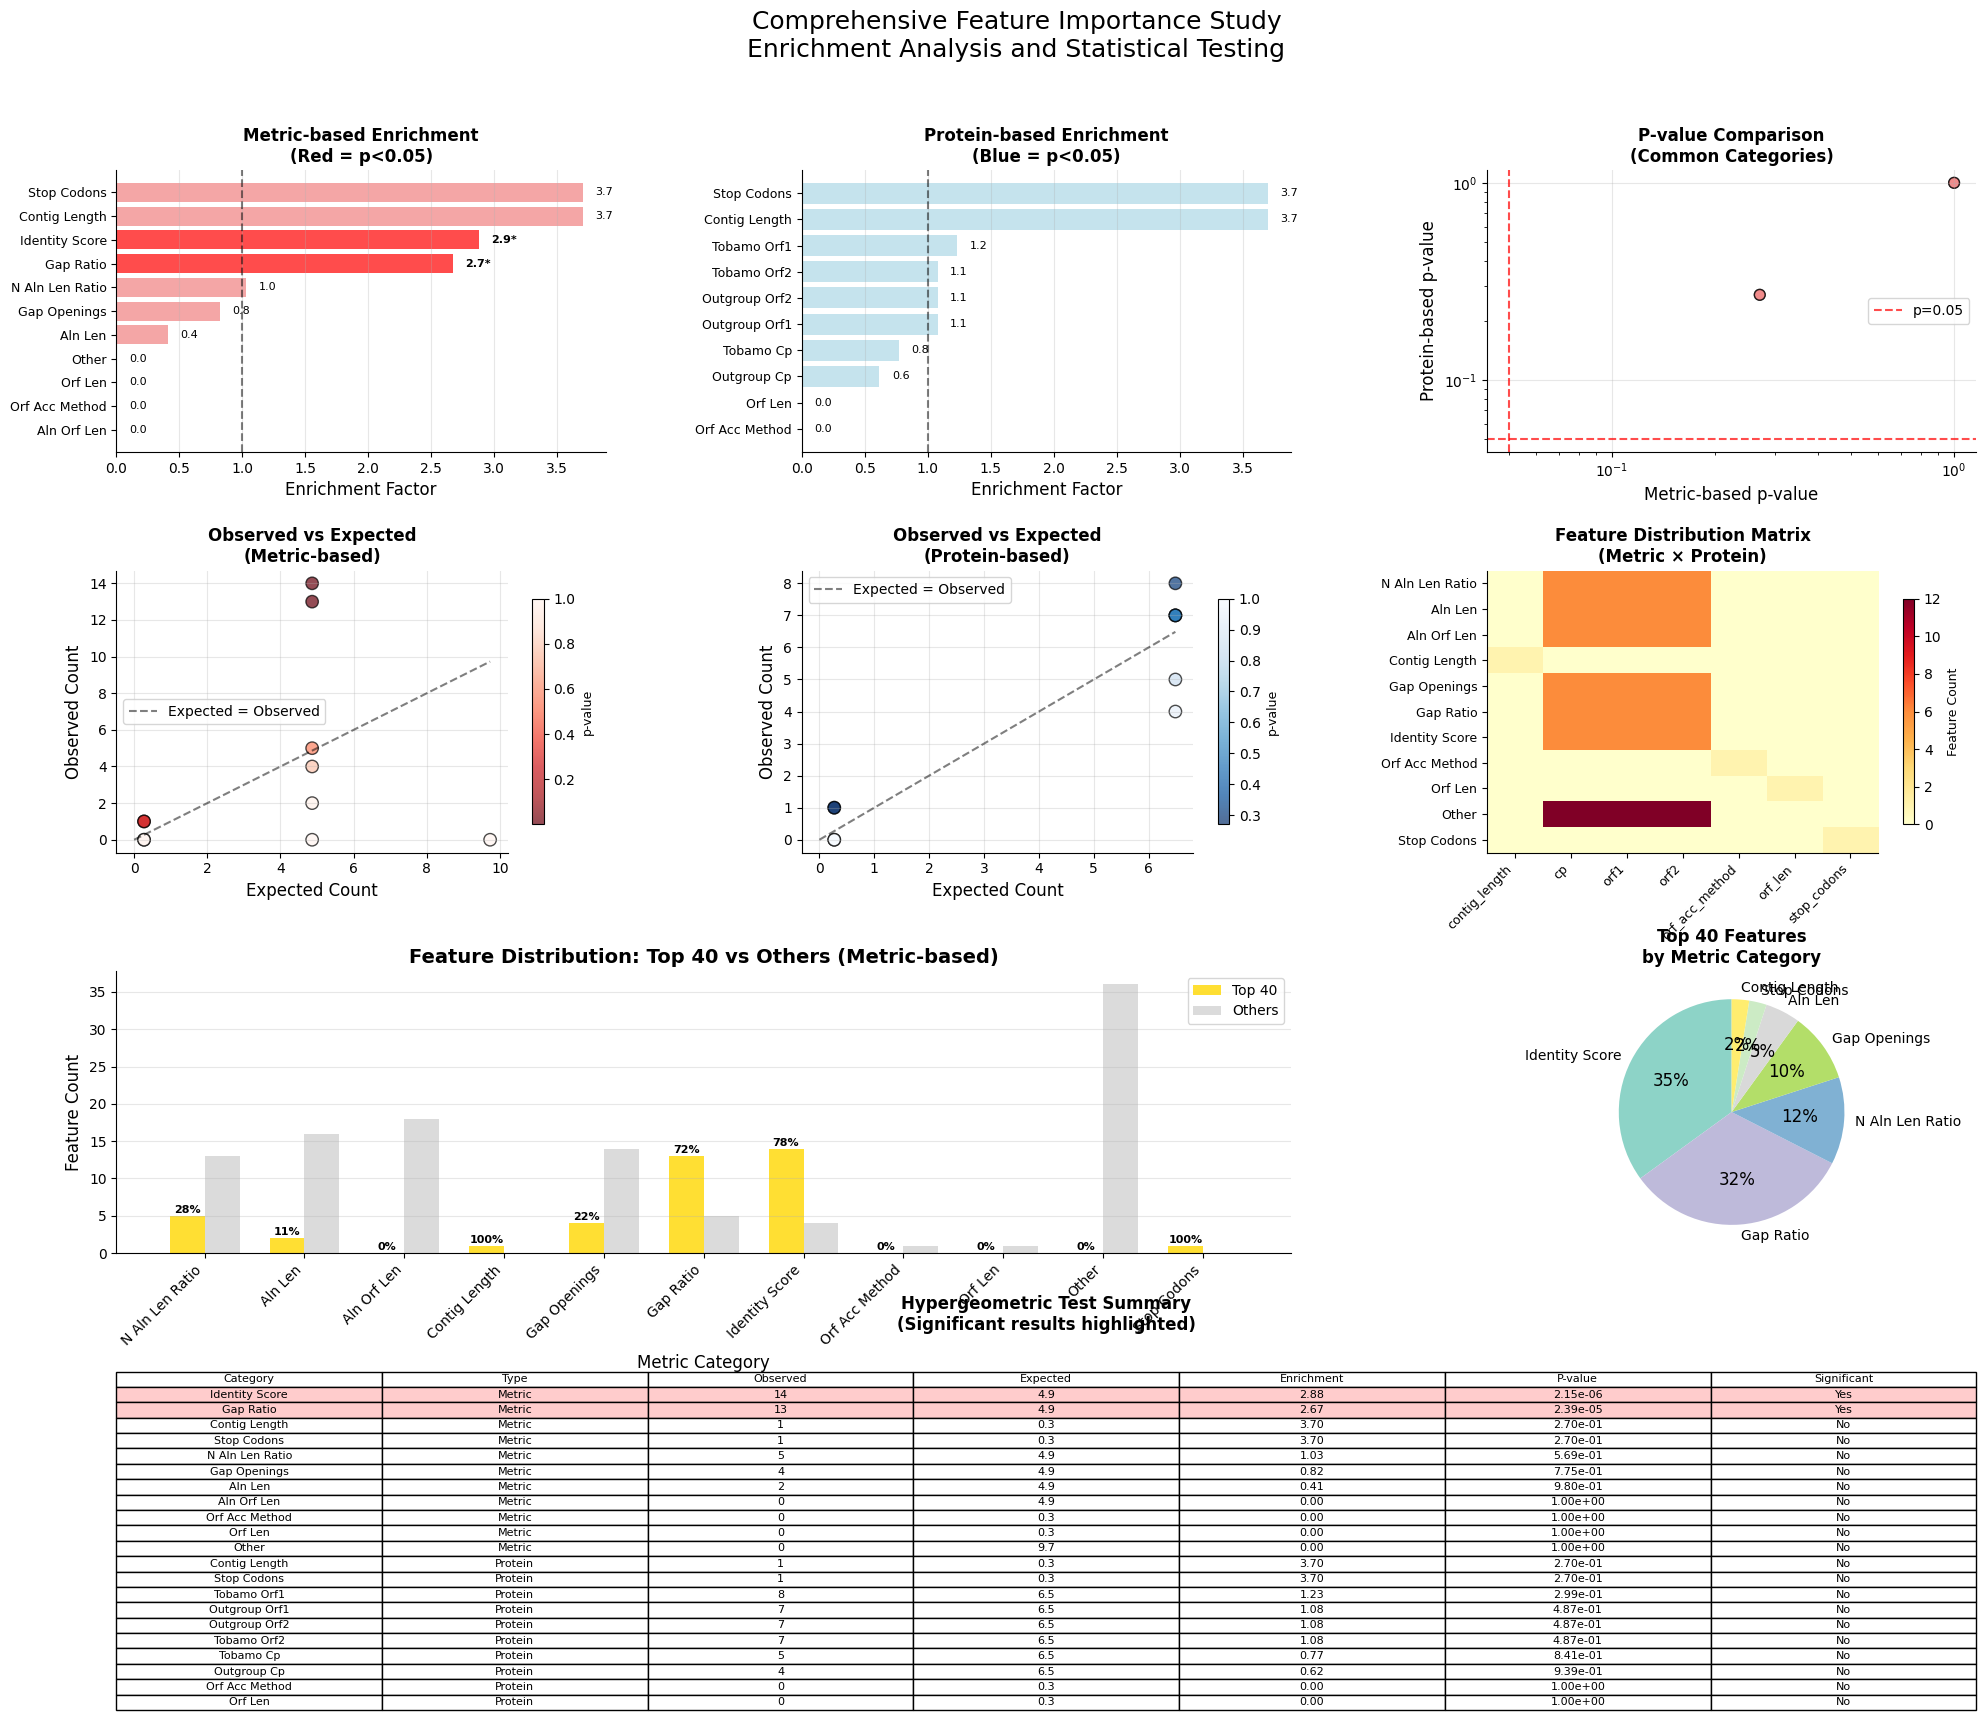

In [13]:
# 7. COMPREHENSIVE VISUALIZATION
print("\n\n7. GENERATING COMPREHENSIVE VISUALIZATIONS")
print("=" * 50)

# Figure 7: Feature Importance Study - Comprehensive Analysis
fig = plt.figure(figsize=(24, 20))

# Create a complex subplot layout with better spacing
gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 1, 1.2], width_ratios=[1, 1, 1], 
                      hspace=0.4, wspace=0.4)

# 1. Metric-based enrichment analysis (top-left)
ax1 = fig.add_subplot(gs[0, 0])
metric_enrichment = metric_hyper_df.sort_values('enrichment_factor', ascending=True)
colors_metric = ['red' if p < 0.05 else 'lightcoral' for p in metric_enrichment['p_value']]
bars1 = ax1.barh(range(len(metric_enrichment)), metric_enrichment['enrichment_factor'], 
                 color=colors_metric, alpha=0.7)
ax1.set_yticks(range(len(metric_enrichment)))
ax1.set_yticklabels([cat.replace('_', ' ').title() for cat in metric_enrichment['category']], fontsize=9)
ax1.set_xlabel('Enrichment Factor')
ax1.set_title('Metric-based Enrichment\n(Red = p<0.05)', fontweight='bold', fontsize=12)
ax1.axvline(x=1, color='black', linestyle='--', alpha=0.5)
ax1.grid(True, alpha=0.3, axis='x')

# Add enrichment values
for i, (bar, enrich, pval) in enumerate(zip(bars1, metric_enrichment['enrichment_factor'], metric_enrichment['p_value'])):
    label = f'{enrich:.1f}' + ('*' if pval < 0.05 else '')
    ax1.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, label,
            ha='left', va='center', fontsize=8, fontweight='bold' if pval < 0.05 else 'normal')

# 2. Protein-based enrichment analysis (top-middle)
ax2 = fig.add_subplot(gs[0, 1])
protein_enrichment = protein_hyper_df.sort_values('enrichment_factor', ascending=True)
colors_protein = ['blue' if p < 0.05 else 'lightblue' for p in protein_enrichment['p_value']]
bars2 = ax2.barh(range(len(protein_enrichment)), protein_enrichment['enrichment_factor'], 
                 color=colors_protein, alpha=0.7)
ax2.set_yticks(range(len(protein_enrichment)))
ax2.set_yticklabels([cat.replace('_', ' ').title() for cat in protein_enrichment['category']], fontsize=9)
ax2.set_xlabel('Enrichment Factor')
ax2.set_title('Protein-based Enrichment\n(Blue = p<0.05)', fontweight='bold', fontsize=12)
ax2.axvline(x=1, color='black', linestyle='--', alpha=0.5)
ax2.grid(True, alpha=0.3, axis='x')

# Add enrichment values
for i, (bar, enrich, pval) in enumerate(zip(bars2, protein_enrichment['enrichment_factor'], protein_enrichment['p_value'])):
    label = f'{enrich:.1f}' + ('*' if pval < 0.05 else '')
    ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, label,
            ha='left', va='center', fontsize=8, fontweight='bold' if pval < 0.05 else 'normal')

# 3. P-value comparison (top-right)
ax3 = fig.add_subplot(gs[0, 2])
# Create scatter plot comparing p-values for categories that exist in both datasets
# We need to match categories between metric and protein analysis
common_categories = []
metric_pvals = []
protein_pvals = []

# Only compare categories that exist in both analyses
for _, metric_row in metric_hyper_df.iterrows():
    metric_cat = metric_row['category']
    # Find corresponding protein category if it exists
    protein_match = protein_hyper_df[protein_hyper_df['category'] == metric_cat]
    if not protein_match.empty:
        common_categories.append(metric_cat)
        metric_pvals.append(metric_row['p_value'])
        protein_pvals.append(protein_match.iloc[0]['p_value'])

if len(metric_pvals) > 0:
    scatter_colors = ['red' if p < 0.05 else 'lightcoral' for p in metric_pvals]
    ax3.scatter(metric_pvals, protein_pvals, 
               s=60, alpha=0.7, c=scatter_colors, edgecolors='black')
    ax3.set_xlabel('Metric-based p-value')
    ax3.set_ylabel('Protein-based p-value')
    ax3.set_title('P-value Comparison\n(Common Categories)', fontweight='bold', fontsize=12)
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='p=0.05')
    ax3.axvline(x=0.05, color='red', linestyle='--', alpha=0.7)
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Add category labels for points
    for i, cat in enumerate(common_categories):
        if metric_pvals[i] < 0.05 or protein_pvals[i] < 0.05:  # Only label significant ones
            ax3.annotate(cat.replace('_', ' ').title(), 
                        (metric_pvals[i], protein_pvals[i]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.7)
else:
    ax3.text(0.5, 0.5, 'No common categories\nfor comparison', 
             ha='center', va='center', transform=ax3.transAxes,
             fontsize=12)

# 4. Observed vs Expected counts - Metrics (second row, left)
ax4 = fig.add_subplot(gs[1, 0])
scatter4 = ax4.scatter(metric_hyper_df['expected'], metric_hyper_df['observed'], 
                      s=80, c=metric_hyper_df['p_value'], cmap='Reds_r', 
                      alpha=0.7, edgecolors='black')
ax4.plot([0, metric_hyper_df['expected'].max()], [0, metric_hyper_df['expected'].max()], 
         'k--', alpha=0.5, label='Expected = Observed')
ax4.set_xlabel('Expected Count')
ax4.set_ylabel('Observed Count')
ax4.set_title('Observed vs Expected\n(Metric-based)', fontweight='bold', fontsize=12)
ax4.grid(True, alpha=0.3)
ax4.legend()
cbar4 = plt.colorbar(scatter4, ax=ax4, shrink=0.8)
cbar4.set_label('p-value', fontsize=9)

# 5. Observed vs Expected counts - Proteins (second row, middle)
ax5 = fig.add_subplot(gs[1, 1])
scatter5 = ax5.scatter(protein_hyper_df['expected'], protein_hyper_df['observed'], 
                      s=80, c=protein_hyper_df['p_value'], cmap='Blues_r', 
                      alpha=0.7, edgecolors='black')
ax5.plot([0, protein_hyper_df['expected'].max()], [0, protein_hyper_df['expected'].max()], 
         'k--', alpha=0.5, label='Expected = Observed')
ax5.set_xlabel('Expected Count')
ax5.set_ylabel('Observed Count')
ax5.set_title('Observed vs Expected\n(Protein-based)', fontweight='bold', fontsize=12)
ax5.grid(True, alpha=0.3)
ax5.legend()
cbar5 = plt.colorbar(scatter5, ax=ax5, shrink=0.8)
cbar5.set_label('p-value', fontsize=9)

# 6. Feature distribution heatmap (second row, right)
ax6 = fig.add_subplot(gs[1, 2])
# Create a matrix of metric vs protein distributions
feature_matrix = components_df.groupby(['metric_category', 'simple_protein']).size().unstack(fill_value=0)
im6 = ax6.imshow(feature_matrix.values, cmap='YlOrRd', aspect='auto')
ax6.set_xticks(range(len(feature_matrix.columns)))
ax6.set_xticklabels(feature_matrix.columns, rotation=45, ha='right', fontsize=9)
ax6.set_yticks(range(len(feature_matrix.index)))
ax6.set_yticklabels([idx.replace('_', ' ').title() for idx in feature_matrix.index], fontsize=9)
ax6.set_title('Feature Distribution Matrix\n(Metric × Protein)', fontweight='bold', fontsize=12)
cbar6 = plt.colorbar(im6, ax=ax6, shrink=0.8)
cbar6.set_label('Feature Count', fontsize=9)

# 7. Top 40 vs All Features comparison - Metrics (third row, spanning 2 columns)
ax7 = fig.add_subplot(gs[2, :2])
metric_comparison = metric_stats[['top40_count', 'total_count']].copy()
metric_comparison['non_top40'] = metric_comparison['total_count'] - metric_comparison['top40_count']

x_pos = np.arange(len(metric_comparison))
width = 0.35

bars_top40 = ax7.bar(x_pos - width/2, metric_comparison['top40_count'], width, 
                     label='Top 40', color='gold', alpha=0.8)
bars_other = ax7.bar(x_pos + width/2, metric_comparison['non_top40'], width, 
                     label='Others', color='lightgray', alpha=0.8)

ax7.set_xlabel('Metric Category')
ax7.set_ylabel('Feature Count')
ax7.set_title('Feature Distribution: Top 40 vs Others (Metric-based)', fontweight='bold')
ax7.set_xticks(x_pos)
ax7.set_xticklabels([cat.replace('_', ' ').title() for cat in metric_comparison.index], rotation=45, ha='right')
ax7.legend()
ax7.grid(True, alpha=0.3, axis='y')

# Add percentage labels
for i, (bar_top, bar_other) in enumerate(zip(bars_top40, bars_other)):
    total = bar_top.get_height() + bar_other.get_height()
    if total > 0:
        pct = (bar_top.get_height() / total) * 100
        ax7.text(bar_top.get_x() + bar_top.get_width()/2, bar_top.get_height() + 0.1,
                f'{pct:.0f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 8. Top features by category pie chart (third row, right)
ax8 = fig.add_subplot(gs[2, 2])
top40_by_metric = components_df[components_df['is_top40']]['metric_category'].value_counts()
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(top40_by_metric)))
wedges, texts, autotexts = ax8.pie(top40_by_metric.values, 
                                  labels=[cat.replace('_', ' ').title() for cat in top40_by_metric.index],
                                  autopct='%1.0f%%',
                                  colors=colors_pie,
                                  startangle=90)
ax8.set_title('Top 40 Features\nby Metric Category', fontweight='bold', fontsize=12)

# 9. Statistical significance summary (bottom row)
ax9 = fig.add_subplot(gs[3, :])
# Create summary table
summary_data = []
for _, row in metric_hyper_df.iterrows():
    summary_data.append([
        row['category'].replace('_', ' ').title(),
        'Metric',
        f"{row['observed']}",
        f"{row['expected']:.1f}",
        f"{row['enrichment_factor']:.2f}",
        f"{row['p_value']:.2e}",
        "Yes" if row['significant'] else "No"
    ])

for _, row in protein_hyper_df.iterrows():
    summary_data.append([
        row['category'].replace('_', ' ').title(),
        'Protein',
        f"{row['observed']}",
        f"{row['expected']:.1f}",
        f"{row['enrichment_factor']:.2f}",
        f"{row['p_value']:.2e}",
        "Yes" if row['significant'] else "No"
    ])

# Create table
table = ax9.table(cellText=summary_data,
                  colLabels=['Category', 'Type', 'Observed', 'Expected', 'Enrichment', 'P-value', 'Significant'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)

# Color significant rows
for i, row in enumerate(summary_data):
    if row[6] == "Yes":  # Significant
        for j in range(len(row)):
            table[(i+1, j)].set_facecolor('#ffcccc')

ax9.axis('off')
ax9.set_title('Hypergeometric Test Summary\n(Significant results highlighted)', 
              fontweight='bold', fontsize=12, pad=30)

plt.suptitle('Comprehensive Feature Importance Study\nEnrichment Analysis and Statistical Testing', 
             fontsize=18, y=0.96)

plt.savefig(figures_dir / 'Figure7_ComprehensiveFeatureStudy.png', dpi=300, bbox_inches='tight')
plt.show()



8. ADDITIONAL VISUALIZATIONS - TOP 40 FEATURE DISTRIBUTION
Creating horizontal bar plots for top 40 feature distribution...


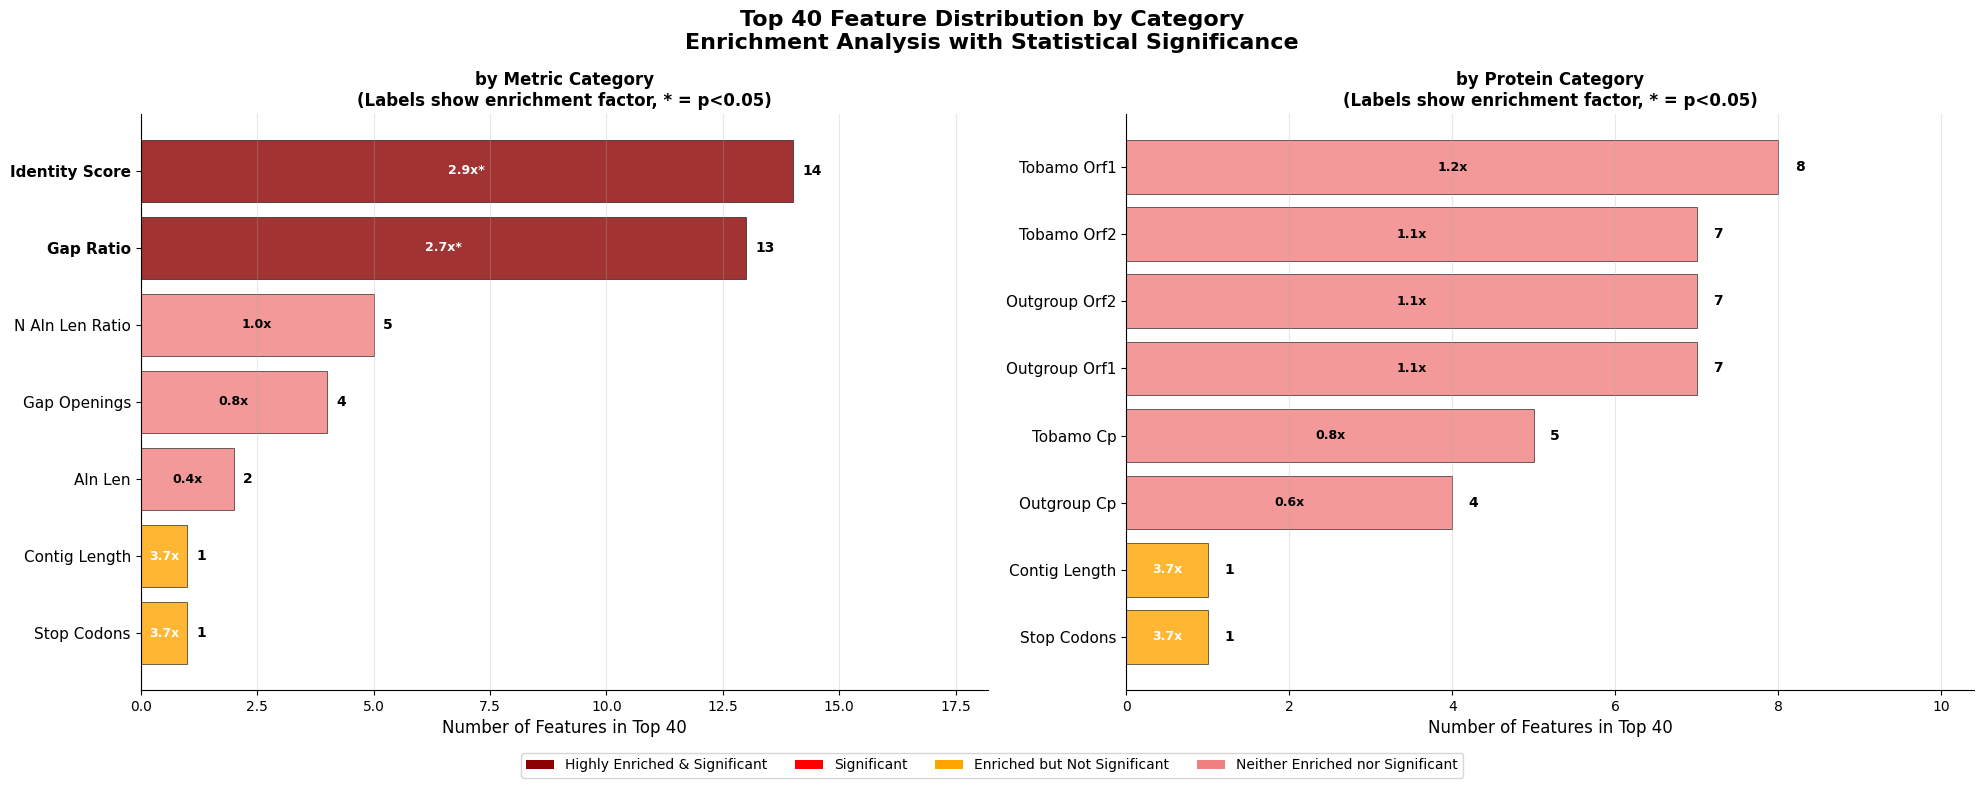


METRIC CATEGORY SUMMARY:
-------------------------
• Stop Codons: 1 features, 3.7x enrichment
• Contig Length: 1 features, 3.7x enrichment
• Aln Len: 2 features, 0.4x enrichment
• Gap Openings: 4 features, 0.8x enrichment
• N Aln Len Ratio: 5 features, 1.0x enrichment
• Gap Ratio: 13 features, 2.7x enrichment (significant)
• Identity Score: 14 features, 2.9x enrichment (significant)

PROTEIN CATEGORY SUMMARY:
-------------------------
• Stop Codons: 1 features, 3.7x enrichment
• Contig Length: 1 features, 3.7x enrichment
• Outgroup Cp: 4 features, 0.6x enrichment
• Tobamo Cp: 5 features, 0.8x enrichment
• Outgroup Orf1: 7 features, 1.1x enrichment
• Outgroup Orf2: 7 features, 1.1x enrichment
• Tobamo Orf2: 7 features, 1.1x enrichment
• Tobamo Orf1: 8 features, 1.2x enrichment


In [18]:
# 8. ADDITIONAL VISUALIZATIONS - TOP 40 FEATURE DISTRIBUTION
print("\n\n8. ADDITIONAL VISUALIZATIONS - TOP 40 FEATURE DISTRIBUTION")
print("=" * 60)

# Create figure with two horizontal bar plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# 1. Top 40 features by metric category with enrichment information
print("Creating horizontal bar plots for top 40 feature distribution...")

# Get top 40 feature counts by metric category
top40_by_metric = components_df[components_df['is_top40']]['metric_category'].value_counts()

# Get enrichment factors for metric categories
metric_enrichment_dict = dict(zip(metric_hyper_df['category'], metric_hyper_df['enrichment_factor']))
metric_pvalue_dict = dict(zip(metric_hyper_df['category'], metric_hyper_df['p_value']))

# Prepare data for metric plot
metric_categories = top40_by_metric.index.tolist()
metric_counts = top40_by_metric.values.tolist()
metric_enrichments = [metric_enrichment_dict.get(cat, 1.0) for cat in metric_categories]
metric_pvalues = [metric_pvalue_dict.get(cat, 1.0) for cat in metric_categories]

# Color bars based on significance and enrichment (same colors for both plots)
colors_metric = []
for i, (enrich, pval) in enumerate(zip(metric_enrichments, metric_pvalues)):
    if pval < 0.05 and enrich > 1.5:
        colors_metric.append('darkred')     # Highly significant and enriched
    elif pval < 0.05:
        colors_metric.append('red')         # Significant
    elif enrich > 1.5:
        colors_metric.append('orange')      # Enriched but not significant
    else:
        colors_metric.append('lightcoral')  # Neither

# Sort by frequency (most frequent on top - reverse order for horizontal bars)
metric_sort_indices = np.argsort(metric_counts)  # ascending order
sorted_metric_categories = [metric_categories[i] for i in metric_sort_indices]
sorted_metric_counts = [metric_counts[i] for i in metric_sort_indices]
sorted_metric_enrichments = [metric_enrichments[i] for i in metric_sort_indices]
sorted_metric_pvalues = [metric_pvalues[i] for i in metric_sort_indices]
sorted_colors_metric = [colors_metric[i] for i in metric_sort_indices]

# Create horizontal bar plot for metrics
bars1 = ax1.barh(range(len(sorted_metric_categories)), sorted_metric_counts, 
                 color=sorted_colors_metric, alpha=0.8, edgecolor='black', linewidth=0.5)

# Add count and enrichment labels
for i, (bar, count, enrich, pval) in enumerate(zip(bars1, sorted_metric_counts, sorted_metric_enrichments, sorted_metric_pvalues)):
    # Add count label
    ax1.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2, 
             f'{count}', ha='left', va='center', fontweight='bold', fontsize=10)
    
    # Add enrichment factor label
    sig_marker = '*' if pval < 0.05 else ''
    ax1.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2, 
             f'{enrich:.1f}x{sig_marker}', ha='center', va='center', 
             fontweight='bold', fontsize=9, color='white' if enrich > 1.5 else 'black')

ax1.set_yticks(range(len(sorted_metric_categories)))
# Bold labels for significantly enriched categories
metric_labels = []
for cat, pval in zip(sorted_metric_categories, sorted_metric_pvalues):
    label = cat.replace('_', ' ').title()
    metric_labels.append(label)
ax1.set_yticklabels(metric_labels, fontsize=11)

# Apply bold formatting to significant categories
for i, (label, pval) in enumerate(zip(ax1.get_yticklabels(), sorted_metric_pvalues)):
    if pval < 0.05:
        label.set_fontweight('bold')
ax1.set_xlabel('Number of Features in Top 40', fontsize=12)
ax1.set_title('by Metric Category\n(Labels show enrichment factor, * = p<0.05)', 
              fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3, axis='x')
ax1.set_xlim(0, max(sorted_metric_counts) * 1.3)

# 2. Top 40 features by protein category with enrichment information
top40_by_protein = components_df[components_df['is_top40']]['protein_category'].value_counts()

# Get enrichment factors for protein categories
protein_enrichment_dict = dict(zip(protein_hyper_df['category'], protein_hyper_df['enrichment_factor']))
protein_pvalue_dict = dict(zip(protein_hyper_df['category'], protein_hyper_df['p_value']))

# Prepare data for protein plot
protein_categories = top40_by_protein.index.tolist()
protein_counts = top40_by_protein.values.tolist()
protein_enrichments = [protein_enrichment_dict.get(cat, 1.0) for cat in protein_categories]
protein_pvalues = [protein_pvalue_dict.get(cat, 1.0) for cat in protein_categories]

# Color bars based on significance and enrichment (same colors for both plots)
colors_protein = []
for i, (enrich, pval) in enumerate(zip(protein_enrichments, protein_pvalues)):
    if pval < 0.05 and enrich > 1.5:
        colors_protein.append('darkred')     # Highly significant and enriched
    elif pval < 0.05:
        colors_protein.append('red')         # Significant
    elif enrich > 1.5:
        colors_protein.append('orange')      # Enriched but not significant
    else:
        colors_protein.append('lightcoral')  # Neither

# Sort by frequency (most frequent on top - reverse order for horizontal bars)
protein_sort_indices = np.argsort(protein_counts)  # ascending order
sorted_protein_categories = [protein_categories[i] for i in protein_sort_indices]
sorted_protein_counts = [protein_counts[i] for i in protein_sort_indices]
sorted_protein_enrichments = [protein_enrichments[i] for i in protein_sort_indices]
sorted_protein_pvalues = [protein_pvalues[i] for i in protein_sort_indices]
sorted_colors_protein = [colors_protein[i] for i in protein_sort_indices]

# Create horizontal bar plot for proteins
bars2 = ax2.barh(range(len(sorted_protein_categories)), sorted_protein_counts, 
                 color=sorted_colors_protein, alpha=0.8, edgecolor='black', linewidth=0.5)

# Add count and enrichment labels
for i, (bar, count, enrich, pval) in enumerate(zip(bars2, sorted_protein_counts, sorted_protein_enrichments, sorted_protein_pvalues)):
    # Add count label
    ax2.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2, 
             f'{count}', ha='left', va='center', fontweight='bold', fontsize=10)
    
    # Add enrichment factor label
    sig_marker = '*' if pval < 0.05 else ''
    ax2.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2, 
             f'{enrich:.1f}x{sig_marker}', ha='center', va='center', 
             fontweight='bold', fontsize=9, color='white' if enrich > 1.5 else 'black')

ax2.set_yticks(range(len(sorted_protein_categories)))
# Bold labels for significantly enriched categories
protein_labels = []
for cat, pval in zip(sorted_protein_categories, sorted_protein_pvalues):
    label = cat.replace('_', ' ').title()
    protein_labels.append(label)
ax2.set_yticklabels(protein_labels, fontsize=11)

# Apply bold formatting to significant categories
for i, (label, pval) in enumerate(zip(ax2.get_yticklabels(), sorted_protein_pvalues)):
    if pval < 0.05:
        label.set_fontweight('bold')
ax2.set_xlabel('Number of Features in Top 40', fontsize=12)
ax2.set_title('by Protein Category\n(Labels show enrichment factor, * = p<0.05)', 
              fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, axis='x')
ax2.set_xlim(0, max(sorted_protein_counts) * 1.3)

# Add color legend (unified color scheme)
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='darkred', label='Highly Enriched & Significant'),
    Patch(facecolor='red', label='Significant'),
    Patch(facecolor='orange', label='Enriched but Not Significant'),
    Patch(facecolor='lightcoral', label='Neither Enriched nor Significant')
]

# Add super title
fig.suptitle('Top 40 Feature Distribution by Category\nEnrichment Analysis with Statistical Significance', 
             fontsize=16, fontweight='bold', y=0.98)

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.06), 
           ncol=4, fontsize=10, frameon=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.13, top=0.85)  # Reduced space for legend and added top margin for title
plt.savefig(figures_dir / 'Figure8_Top40FeatureDistribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nMETRIC CATEGORY SUMMARY:")
print("-" * 25)
for cat, count, enrich, pval in zip(sorted_metric_categories, sorted_metric_counts, sorted_metric_enrichments, sorted_metric_pvalues):
    sig_text = " (significant)" if pval < 0.05 else ""
    print(f"• {cat.replace('_', ' ').title()}: {count} features, {enrich:.1f}x enrichment{sig_text}")

print(f"\nPROTEIN CATEGORY SUMMARY:")
print("-" * 25)
for cat, count, enrich, pval in zip(sorted_protein_categories, sorted_protein_counts, sorted_protein_enrichments, sorted_protein_pvalues):
    sig_text = " (significant)" if pval < 0.05 else ""
    print(f"• {cat.replace('_', ' ').title()}: {count} features, {enrich:.1f}x enrichment{sig_text}")



9. SEPARATE METRIC AND PROTEIN ENRICHMENT ANALYSIS
Creating metric categories analysis...
Creating protein categories analysis...


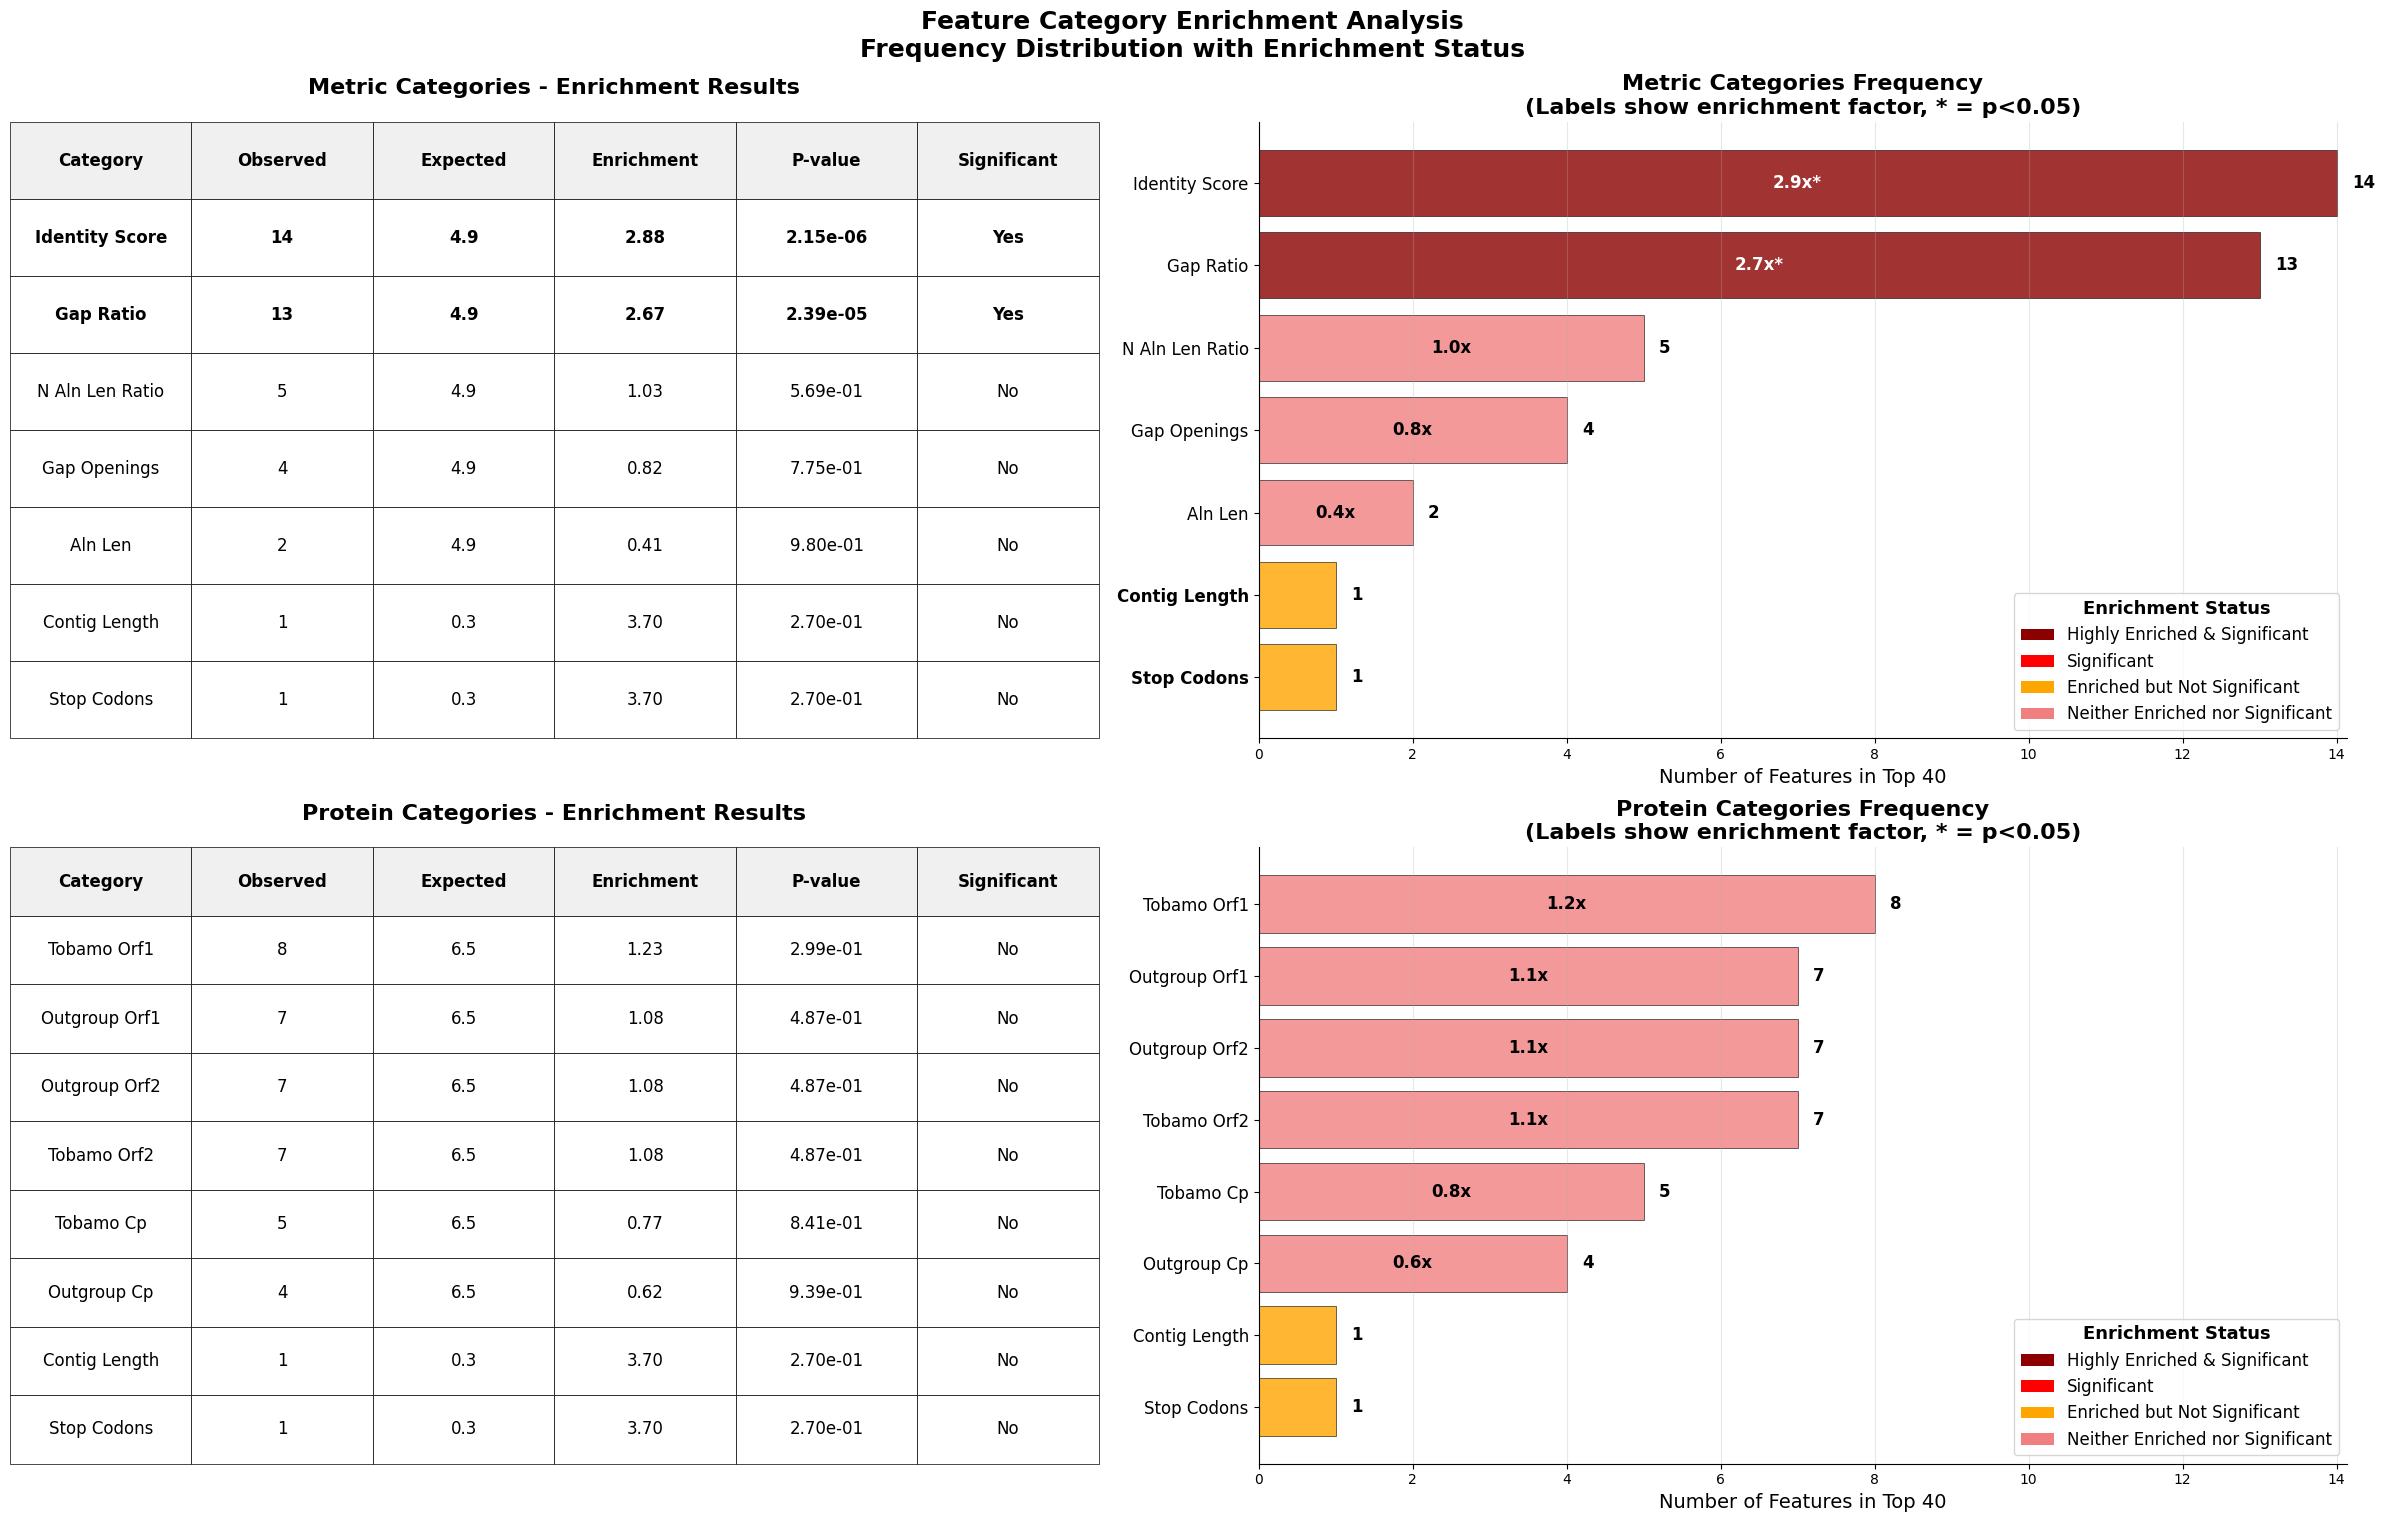


METRIC CATEGORIES SUMMARY:
------------------------------
Total metric categories: 7
Significantly enriched: 2
Most frequent: Identity Score - 14 features
  └─ Statistically significant (p = 2.15e-06)

PROTEIN CATEGORIES SUMMARY:
------------------------------
Total protein categories: 8
Significantly enriched: 0
Most frequent: Tobamo Orf1 - 8 features
  └─ Not statistically significant (p = 2.99e-01)


In [36]:
# 9. SEPARATE METRIC AND PROTEIN ENRICHMENT ANALYSIS
print("\n\n9. SEPARATE METRIC AND PROTEIN ENRICHMENT ANALYSIS")
print("=" * 60)

# Create figure with 2 rows: metrics on top, proteins on bottom
fig, ((ax_metric_table, ax_metric_bars), (ax_protein_table, ax_protein_bars)) = plt.subplots(2, 2, figsize=(24, 16))

# === METRIC CATEGORIES ANALYSIS ===
print("Creating metric categories analysis...")

# Prepare metric data sorted by observed frequency (descending) - only include categories with observed > 0
metric_data = []
for _, row in metric_hyper_df.sort_values('observed', ascending=False).iterrows():
    if row['observed'] > 0:  # Only include categories that have features in top 40
        metric_data.append({
            'category': row['category'].replace('_', ' ').title(),
            'observed': row['observed'],
            'expected': row['expected'],
            'enrichment': row['enrichment_factor'],
            'pvalue': row['p_value'],
            'significant': row['significant']
        })

# Prepare metric table data
metric_table_data = []
for item in metric_data:
    metric_table_data.append([
        item['category'],
        f"{item['observed']}",
        f"{item['expected']:.1f}",
        f"{item['enrichment']:.2f}",
        f"{item['pvalue']:.2e}",
        "Yes" if item['significant'] else "No"
    ])

# Create metric table
metric_table = ax_metric_table.table(cellText=metric_table_data,
                                    colLabels=['Category', 'Observed', 'Expected', 'Enrichment', 'P-value', 'Significant'],
                                    cellLoc='center',
                                    loc='center',
                                    bbox=[0, 0, 1, 1])

metric_table.auto_set_font_size(False)
metric_table.set_fontsize(12)
metric_table.scale(1, 2)

# Color significant rows in metric table and make them bold
for i, item in enumerate(metric_data):
    if item['significant']:
        for j in range(6):  # Now 6 columns including Significant
            metric_table[(i+1, j)].set_text_props(weight='bold')

# Style metric table
for (i, j), cell in metric_table.get_celld().items():
    if i == 0:  # Header row
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#f0f0f0')
    cell.set_edgecolor('black')
    cell.set_linewidth(0.5)

ax_metric_table.axis('off')
ax_metric_table.set_title('Metric Categories - Enrichment Results', 
                         fontweight='bold', fontsize=16, pad=20)

# Create metric horizontal frequency histogram
metric_categories = [item['category'] for item in metric_data]
metric_observed = [item['observed'] for item in metric_data]
metric_enrichments = [item['enrichment'] for item in metric_data]
metric_significants = [item['significant'] for item in metric_data]

# Color bars based on enrichment level (not metric type)
metric_colors = []
for sig, enrich in zip(metric_significants, metric_enrichments):
    if sig and enrich > 1.5:
        metric_colors.append('darkred')     # Highly significant and enriched
    elif sig:
        metric_colors.append('red')         # Significant
    elif enrich > 1.5:
        metric_colors.append('orange')      # Enriched but not significant
    else:
        metric_colors.append('lightcoral')  # Neither

# Reverse order for horizontal bars so most frequent appears at top
metric_y_positions = range(len(metric_categories))
metric_bars = ax_metric_bars.barh(metric_y_positions[::-1], metric_observed, 
                                 color=metric_colors, alpha=0.8, edgecolor='black', linewidth=0.5)

# Add frequency and enrichment labels for metrics
for i, (bar, observed, enrich, sig) in enumerate(zip(metric_bars, metric_observed, metric_enrichments, metric_significants)):
    # Add frequency label
    ax_metric_bars.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2, 
                       f'{observed}', ha='left', va='center', fontweight='bold', fontsize=12)
    
    # Add enrichment factor label inside bar (only if bar is wide enough)
    if bar.get_width() > 1:  # Only show enrichment label if bar is wide enough
        sig_marker = '*' if sig else ''
        text_color = 'white' if enrich > 1.5 else 'black'
        ax_metric_bars.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2, 
                           f'{enrich:.1f}x{sig_marker}', ha='center', va='center', 
                           fontweight='bold', fontsize=12, color=text_color)

# Customize metric bar plot
ax_metric_bars.set_yticks(metric_y_positions[::-1])
ax_metric_bars.set_yticklabels(metric_categories, fontsize=12)
ax_metric_bars.set_xlabel('Number of Features in Top 40', fontsize=14)
ax_metric_bars.set_title('Metric Categories Frequency\n(Labels show enrichment factor, * = p<0.05)', 
                         fontweight='bold', fontsize=16)
ax_metric_bars.grid(True, alpha=0.3, axis='x')
ax_metric_bars.set_xlim(0, max(metric_observed) * 1.01)

# Bold labels for significant metric categories - fix the comparison logic
y_labels = ax_metric_bars.get_yticklabels()
reversed_significants = metric_significants[::-1]  # Reverse to match the y-axis order
for i, (label, is_significant) in enumerate(zip(y_labels, reversed_significants)):
    if is_significant:
        label.set_fontweight('bold')

# === PROTEIN CATEGORIES ANALYSIS ===
print("Creating protein categories analysis...")

# Prepare protein data sorted by observed frequency (descending) - only include categories with observed > 0
protein_data = []
for _, row in protein_hyper_df.sort_values('observed', ascending=False).iterrows():
    if row['observed'] > 0:  # Only include categories that have features in top 40
        protein_data.append({
            'category': row['category'].replace('_', ' ').title(),
            'observed': row['observed'],
            'expected': row['expected'],
            'enrichment': row['enrichment_factor'],
            'pvalue': row['p_value'],
            'significant': row['significant']
        })

# Prepare protein table data
protein_table_data = []
for item in protein_data:
    protein_table_data.append([
        item['category'],
        f"{item['observed']}",
        f"{item['expected']:.1f}",
        f"{item['enrichment']:.2f}",
        f"{item['pvalue']:.2e}",
        "Yes" if item['significant'] else "No"
    ])

# Create protein table
protein_table = ax_protein_table.table(cellText=protein_table_data,
                                      colLabels=['Category', 'Observed', 'Expected', 'Enrichment', 'P-value', 'Significant'],
                                      cellLoc='center',
                                      loc='center',
                                      bbox=[0, 0, 1, 1])

protein_table.auto_set_font_size(False)
protein_table.set_fontsize(12)
protein_table.scale(1, 2)

# Color significant rows in protein table and make them bold
for i, item in enumerate(protein_data):
    if item['significant']:
        for j in range(6):  # Now 6 columns including Significant
            protein_table[(i+1, j)].set_text_props(weight='bold')

# Style protein table
for (i, j), cell in protein_table.get_celld().items():
    if i == 0:  # Header row
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#f0f0f0')
    cell.set_edgecolor('black')
    cell.set_linewidth(0.5)

ax_protein_table.axis('off')
ax_protein_table.set_title('Protein Categories - Enrichment Results', 
                          fontweight='bold', fontsize=16, pad=20)

# Create protein horizontal frequency histogram
protein_categories = [item['category'] for item in protein_data]
protein_observed = [item['observed'] for item in protein_data]
protein_enrichments = [item['enrichment'] for item in protein_data]
protein_significants = [item['significant'] for item in protein_data]

# Color bars based on enrichment level (not protein type)
protein_colors = []
for sig, enrich in zip(protein_significants, protein_enrichments):
    if sig and enrich > 1.5:
        protein_colors.append('darkred')      # Highly significant and enriched
    elif sig:
        protein_colors.append('red')          # Significant
    elif enrich > 1.5:
        protein_colors.append('orange')      # Enriched but not significant
    else:
        protein_colors.append('lightcoral')  # Neither

# Reverse order for horizontal bars so most frequent appears at top
protein_y_positions = range(len(protein_categories))
protein_bars = ax_protein_bars.barh(protein_y_positions[::-1], protein_observed, 
                                   color=protein_colors, alpha=0.8, edgecolor='black', linewidth=0.5)

# Add frequency and enrichment labels for proteins
for i, (bar, observed, enrich, sig) in enumerate(zip(protein_bars, protein_observed, protein_enrichments, protein_significants)):
    # Add frequency label
    ax_protein_bars.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2, 
                        f'{observed}', ha='left', va='center', fontweight='bold', fontsize=12)
    
    # Add enrichment factor label inside bar (only if bar is wide enough)
    if bar.get_width() > 1:  # Only show enrichment label if bar is wide enough
        sig_marker = '*' if sig else ''
        text_color = 'white' if enrich > 1.5 else 'black'
        ax_protein_bars.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2, 
                            f'{enrich:.1f}x{sig_marker}', ha='center', va='center', 
                            fontweight='bold', fontsize=12, color=text_color)

# Customize protein bar plot
ax_protein_bars.set_yticks(protein_y_positions[::-1])
ax_protein_bars.set_yticklabels(protein_categories, fontsize=12)
ax_protein_bars.set_xlabel('Number of Features in Top 40', fontsize=14)
ax_protein_bars.set_title('Protein Categories Frequency\n(Labels show enrichment factor, * = p<0.05)', 
                         fontweight='bold', fontsize=16)
ax_protein_bars.grid(True, alpha=0.3, axis='x')

# Set shared x-axis scale for both plots
max_observed = max(max(metric_observed), max(protein_observed))
ax_metric_bars.set_xlim(0, max_observed * 1.01)
ax_protein_bars.set_xlim(0, max_observed * 1.01)

# Bold labels for significant protein categories - fix the comparison logic
y_labels = ax_protein_bars.get_yticklabels()
reversed_protein_significants = protein_significants[::-1]  # Reverse to match the y-axis order
for i, (label, is_significant) in enumerate(zip(y_labels, reversed_protein_significants)):
    if is_significant:
        label.set_fontweight('bold')

# Add unified legend (same for both plots since color coding is by enrichment)
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='darkred', label='Highly Enriched & Significant'),
    Patch(facecolor='red', label='Significant'),
    Patch(facecolor='orange', label='Enriched but Not Significant'),
    Patch(facecolor='lightcoral', label='Neither Enriched nor Significant')
]

ax_metric_bars.legend(handles=legend_elements, loc='lower right', fontsize=12, frameon=True, title='Enrichment Status', title_fontproperties={'weight': 'bold', 'size': 13})
ax_protein_bars.legend(handles=legend_elements, loc='lower right', fontsize=12, frameon=True, title='Enrichment Status', title_fontproperties={'weight': 'bold', 'size': 13})

# Add super title
fig.suptitle('Feature Category Enrichment Analysis\nFrequency Distribution with Enrichment Status', 
             fontsize=18, fontweight='bold', y=0.95)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.savefig(figures_dir / 'Figure9_SeparateEnrichmentAnalysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nMETRIC CATEGORIES SUMMARY:")
print("-" * 30)
print(f"Total metric categories: {len(metric_data)}")
print(f"Significantly enriched: {sum(1 for item in metric_data if item['significant'])}")
if metric_data:
    print(f"Most frequent: {metric_data[0]['category']} - {metric_data[0]['observed']} features")
    if metric_data[0]['significant']:
        print(f"  └─ Statistically significant (p = {metric_data[0]['pvalue']:.2e})")
    else:
        print(f"  └─ Not statistically significant (p = {metric_data[0]['pvalue']:.2e})")

print(f"\nPROTEIN CATEGORIES SUMMARY:")
print("-" * 30)
print(f"Total protein categories: {len(protein_data)}")
print(f"Significantly enriched: {sum(1 for item in protein_data if item['significant'])}")
if protein_data:
    print(f"Most frequent: {protein_data[0]['category']} - {protein_data[0]['observed']} features")
    if protein_data[0]['significant']:
        print(f"  └─ Statistically significant (p = {protein_data[0]['pvalue']:.2e})")
    else:
        print(f"  └─ Not statistically significant (p = {protein_data[0]['pvalue']:.2e})")

In [ ]:
# 9. SUMMARY STATISTICS AND CONCLUSIONS
print("\n\n8. COMPREHENSIVE SUMMARY")
print("=" * 70)

print("FEATURE COMPOSITION SUMMARY:")
print("-" * 30)
print(f"• Total features in model: {len(all_features)}")
print(f"• Features in top 40: {len(feature_importance)}")
print(f"• Basic features (orf_len, contig_length, stop_codons, orf_acc_method): {components_df['is_basic'].sum()}")
print(f"• Complex alignment features: {(~components_df['is_basic']).sum()}")

# Show which basic features are in top 40
basic_in_top40 = components_df[components_df['is_basic'] & components_df['is_top40']]['feature_name'].tolist()
if basic_in_top40:
    print(f"• Basic features in top 40: {basic_in_top40}")
else:
    print(f"• No basic features in top 40")

print(f"\nMETRIC-BASED ANALYSIS:")
print("-" * 25)
significant_metrics = metric_hyper_df[metric_hyper_df['significant']]
print(f"• Significantly enriched metric types: {len(significant_metrics)}")
if len(significant_metrics) > 0:
    print("• Most enriched metric categories:")
    for _, row in significant_metrics.nlargest(3, 'enrichment_factor').iterrows():
        print(f"  - {row['category'].replace('_', ' ').title()}: {row['enrichment_factor']:.2f}x enrichment (p={row['p_value']:.2e})")

print(f"\nPROTEIN-BASED ANALYSIS:")
print("-" * 25)
significant_proteins = protein_hyper_df[protein_hyper_df['significant']]
print(f"• Significantly enriched protein categories: {len(significant_proteins)}")
if len(significant_proteins) > 0:
    print("• Most enriched protein categories:")
    for _, row in significant_proteins.nlargest(3, 'enrichment_factor').iterrows():
        print(f"  - {row['category'].replace('_', ' ').title()}: {row['enrichment_factor']:.2f}x enrichment (p={row['p_value']:.2e})")

print(f"\nKEY INSIGHTS:")
print("-" * 15)

# Most important metric type
top_metric_in_top40 = components_df[components_df['is_top40']]['metric_category'].value_counts()
if len(top_metric_in_top40) > 0:
    print(f"• Most frequent metric in top 40: {top_metric_in_top40.index[0].replace('_', ' ').title()} ({top_metric_in_top40.iloc[0]} features)")

# Most important protein type
top_protein_in_top40 = components_df[components_df['is_top40']]['simple_protein'].value_counts()
if len(top_protein_in_top40) > 0:
    print(f"• Most frequent protein in top 40: {top_protein_in_top40.index[0].replace('_', ' ').title()} ({top_protein_in_top40.iloc[0]} features)")

# Sequence type preference (excluding basic features)
seq_type_in_top40 = components_df[components_df['is_top40'] & (~components_df['is_basic'])]['sequence_type'].value_counts()
if len(seq_type_in_top40) > 0:
    print(f"• Sequence type preference (complex features): {seq_type_in_top40.index[0].title()} ({seq_type_in_top40.iloc[0]} features)")

# Average importance by category
print(f"\n• Average importance by metric category:")
metric_avg_importance = components_df[components_df['is_top40']].groupby('metric_category')['importance'].mean().sort_values(ascending=False)
for metric, avg_imp in metric_avg_importance.head(3).items():
    print(f"  - {metric.replace('_', ' ').title()}: {avg_imp:.6f}")

print(f"\nSTATISTICAL SIGNIFICANCE:")
print("-" * 25)
print(f"• Metric categories with p < 0.05: {(metric_hyper_df['p_value'] < 0.05).sum()}/{len(metric_hyper_df)}")
print(f"• Protein categories with p < 0.05: {(protein_hyper_df['p_value'] < 0.05).sum()}/{len(protein_hyper_df)}")

# Bonferroni correction
alpha_bonferroni_metric = 0.05 / len(metric_hyper_df)
alpha_bonferroni_protein = 0.05 / len(protein_hyper_df)
print(f"• Bonferroni-corrected significance threshold (metrics): p < {alpha_bonferroni_metric:.4f}")
print(f"• Bonferroni-corrected significance threshold (proteins): p < {alpha_bonferroni_protein:.4f}")

bonferroni_sig_metrics = (metric_hyper_df['p_value'] < alpha_bonferroni_metric).sum()
bonferroni_sig_proteins = (protein_hyper_df['p_value'] < alpha_bonferroni_protein).sum()
print(f"• Bonferroni-significant metric categories: {bonferroni_sig_metrics}")
print(f"• Bonferroni-significant protein categories: {bonferroni_sig_proteins}")

print(f"\nCONCLUSIONS:")
print("-" * 15)
print("• The feature importance analysis reveals systematic patterns in the model's reliance on specific")
print("  alignment metrics and protein regions.")
print("• Hypergeometric testing confirms that certain feature types are significantly overrepresented")
print("  in the top 40 most important features compared to random sampling.")
print("• This suggests that the model has learned to focus on specific biological and computational")
print("  features that are most discriminative for tobamovirus classification.")

print("\n" + "=" * 70)
print("FEATURE IMPORTANCE STUDY COMPLETE")
print("=" * 70)



8. COMPREHENSIVE SUMMARY
FEATURE COMPOSITION SUMMARY:
------------------------------
• Total features in model: 148
• Features in top 40: 40
• Basic features (orf_len, contig_length, stop_codons, orf_acc_method): 4
• Complex alignment features: 144
• Basic features in top 40: ['stop_codons', 'contig_length']

METRIC-BASED ANALYSIS:
-------------------------
• Significantly enriched metric types: 2
• Most enriched metric categories:
  - Identity Score: 2.88x enrichment (p=2.15e-06)
  - Gap Ratio: 2.67x enrichment (p=2.39e-05)

PROTEIN-BASED ANALYSIS:
-------------------------
• Significantly enriched protein categories: 0

KEY INSIGHTS:
---------------
• Most frequent metric in top 40: Identity Score (14 features)
• Most frequent protein in top 40: Orf1 (15 features)
• Sequence type preference (complex features): Tobamo (20 features)

• Average importance by metric category:
  - Stop Codons: 0.016285
  - Identity Score: 0.013450
  - Contig Length: 0.012920

STATISTICAL SIGNIFICANCE:
-